In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ml

In [2]:
ml.plot.config_plot()

## Dados

In [5]:
df = pd.read_csv('../data/trab4.data', header=None)
X = df[[0, 1, 2, 3]]
y = df[[4]]

X = ml.data.standard_scaler(X)

In [6]:
X

,0,1,2,3
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593
...,...,...,...,...
145,1.034539,-0.124540,0.816888,1.443121
146,0.551486,-1.277692,0.703536,0.918985
147,0.793012,-0.124540,0.816888,1.050019
148,0.430722,0.797981,0.930239,1.443121


In [7]:
X, y = X.values, y.values

## K-means

In [8]:
class KMeans():
    def __init__(self, n_clusters=8, max_iter=300, tool=0.0001):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tool = tool
        self.cluster_centers_ = None
        self.inertia_ = None
        self.labels_ = None

    def fit(self, X):
        self.cluster_centers_ = self._calculate_initial_centers(X)
        self.labels_ = self._all_nearest_centroids(X)
        old_inertia = self._inertia(X)

        for _ in range(self.max_iter):
            self.cluster_centers_ = self._update_centroids(X)
            self.labels_ = self._all_nearest_centroids(X)
            self.inertia_ = self._inertia(X)
            if np.abs(old_inertia - self.inertia_) < self.tool:
                break
            old_inertia = self.inertia_
        return self

    def predict(self, X):
        return self._all_nearest_centroids(X)

    def _calculate_initial_centers(self, dataset):
        return np.random.uniform(
            dataset.min(axis=0),
            dataset.max(axis=0),
            (self.n_clusters, dataset.shape[1])
        )

    def _nearest_centroid(self, a):
        distances = np.zeros(self.cluster_centers_.shape[0])

        for i, centroid in enumerate(self.cluster_centers_):
            distances[i] = ml.metrics.euclidean_distance(a, centroid)

        return np.argmin(distances)

    def _all_nearest_centroids(self, dataset):
        nearest_indexes = np.zeros(dataset.shape[0])

        for i, a in enumerate(dataset):
            nearest_indexes[i] = self._nearest_centroid(a)

        return nearest_indexes


    def _inertia(self, dataset):
        inertia = 0
        for i, centroid in enumerate(self.cluster_centers_):
            dataframe = dataset[self.labels_ == i, :]
            for a in dataframe:
                inertia += np.square(ml.metrics.euclidean_distance(a, centroid))

        return inertia

    def _update_centroids(self, dataset):
        for i, centroid in enumerate(self.cluster_centers_):
            dataframe = dataset[self.labels_ == i, :]
            if dataframe.shape[0] != 0:
                self.cluster_centers_[i] = np.mean(dataframe, axis=0)
        return self.cluster_centers_

In [9]:
def metodo_cotovelo(dataset, k):
    inertias = np.zeros(k)
    ks = np.arange(1, k + 1)

    for i, k in enumerate(ks):
        inertias[i] = KMeans(n_clusters=k).fit(dataset).inertia_
    
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('k value')
    plt.ylabel('Inertia value')
    plt.title('Elbow Method')
    plt.show()

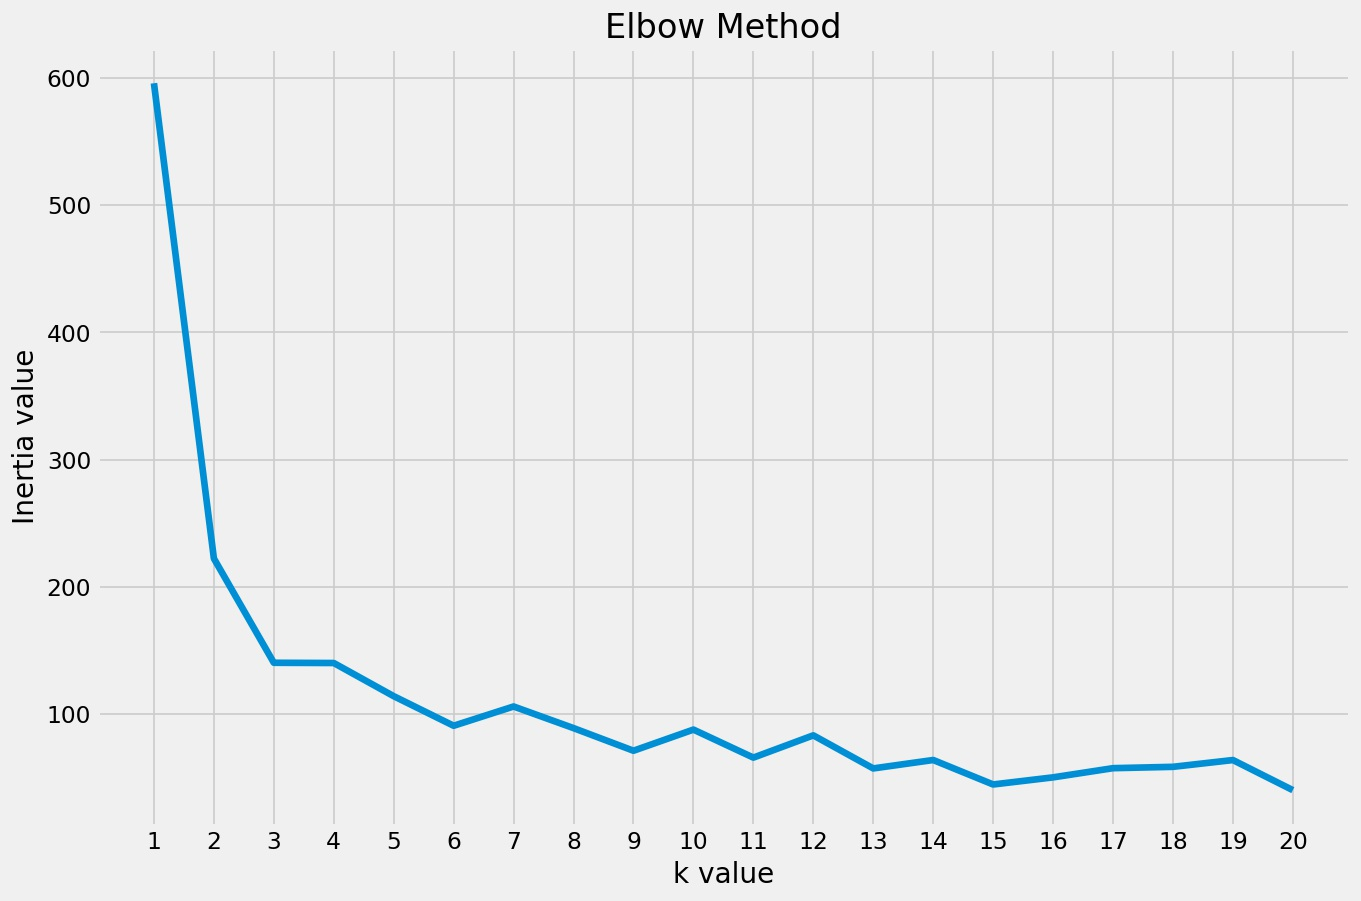

In [10]:
metodo_cotovelo(X, 20)

Observando o gráfico do Método do Cotovelo, o valor da inércia para de diminuir de forma signicativa a partir de K=6, portanto, este seria o melhor valor de K a ser escolhido.

## PCA

In [11]:
class PCA():
    def __init__(self, n_components=None, exp_variance=None):
        self.n_components = n_components
        self.exp_variance = exp_variance
        self.explained_variances_ratio = None
    
    def fit(self, X):
        cov_mat = ml.math.covariance_matrix(X.T)
        values, vectors = np.linalg.eig(cov_mat)
        explained_variances = []
        for value in values:
            explained_variances.append(value / np.sum(values))
        self.explained_variances = np.array(explained_variances)
        self.vectors = vectors
    
    def transform(self, X):
        pc = np.zeros_like(X)
        for i, v in enumerate(self.vectors.T):
            if self.n_components and i == self.n_components:
                break
            if self.exp_variance and np.sum(self.explained_variances[:i]) >= self.exp_variance:
                break
            pc[:, i] = X @ v
        self.explained_variance_ratio = self.explained_variances[:i]
        return pc[:, :i]

In [12]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

In [13]:
print(
    'Variância preservada por componente:\n\tPC1: {0[0]}\tPC2: {0[1]}'.format(
        pca.explained_variance_ratio
    )
)
print('Variância preservada total: {}'.format(pca.explained_variance_ratio.sum()))

Variância preservada por componente:
	PC1: 0.7277045209380133	PC2: 0.23030523267680608
Variância preservada total: 0.9580097536148193


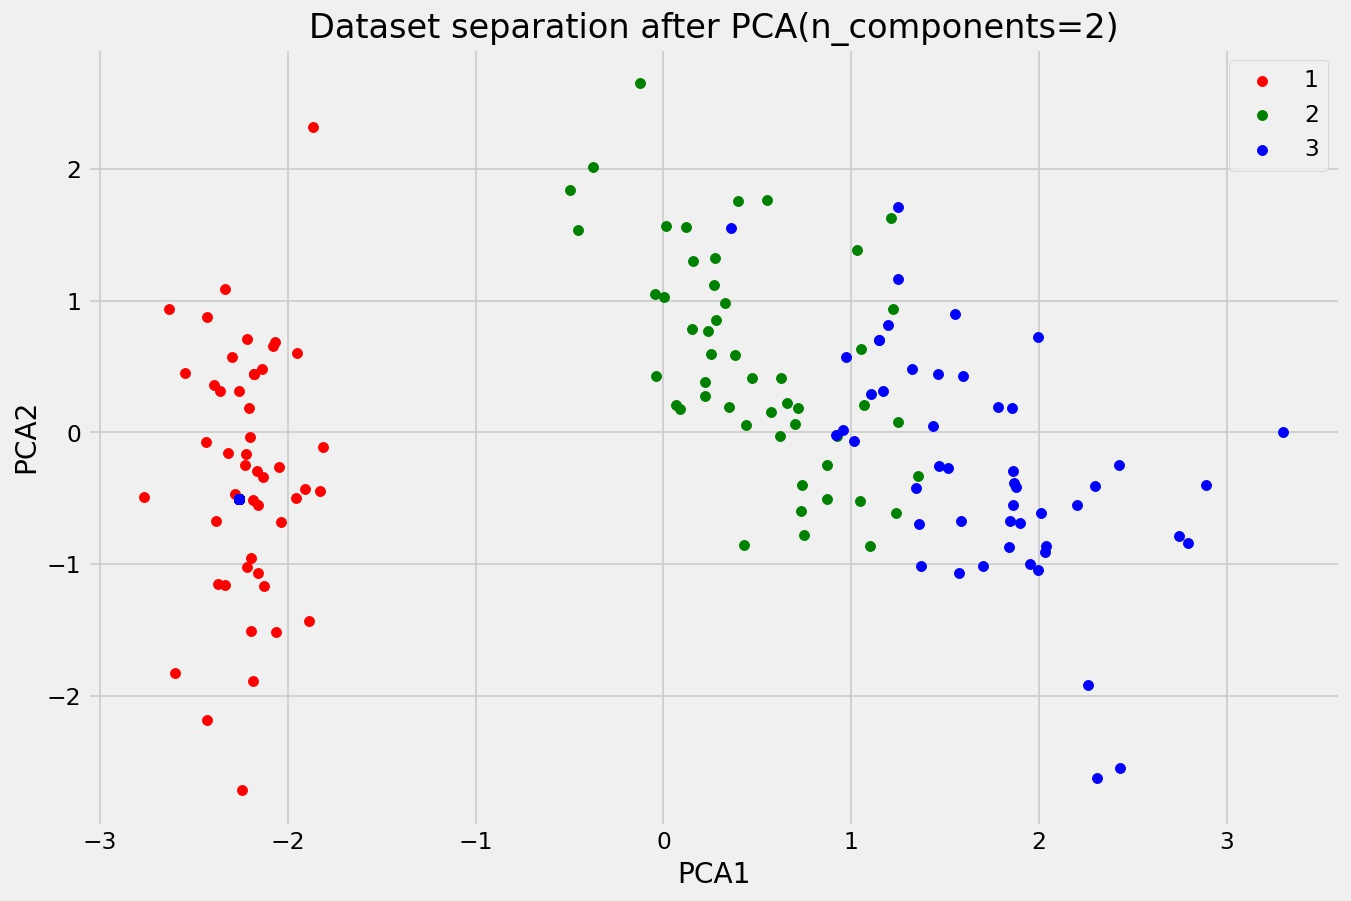

In [14]:
colors = {1: 'red', 2: 'green', 3: 'blue'}
for label in np.unique(y):
    mask = np.where(y == label)
    plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1], c=colors[label], label=label)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Dataset separation after PCA(n_components=2)')
plt.legend()
plt.show()

## Árvores de Decisão

In [15]:
class No:
    def __init__(self, data, output):
        self.data = data
        self.children = {}
        self.output = output
        self.index = -1
        
    def add_child(self, feature_value, obj):
        self.children[feature_value] = obj

In [16]:
class ArvoreDeDecisao:
    def __init__(self):
        self._root = None
    
    def fit(self, X, y):
        features = np.arange(X.shape[1]).tolist()
        classes = np.unique(y)
        level = 0
        self._root = self._decision_tree(X, y, features, level, classes)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(len(X)):
            y_pred[i] = self._predict_for(X[i], self._root)
        return y_pred

    def _count_unique(self, Y):
        u, c = np.unique(Y, return_counts=True)
        return { k: v for k, v in zip(u, c)}

    def _gini_index(self, Y): 
        count = self._count_unique(Y)
        gini_index = 1
        total = len(Y)
        for c in count.values():
            p = c / total
            gini_index -= p ** 2
        return gini_index

    def _gini_gain(self, X, Y, selected_feature):
        gini_orig = self._gini_index(Y)
        gini_split_f = 0
        values = np.unique(X[:, selected_feature])
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y
        initial_size = df.shape[0] 
        for i in values:
            df1 = df[df[selected_feature] == i]
            current_size = df1.shape[0]
            gini_split_f += (current_size / initial_size) * self._gini_index(df1[df1.shape[1] - 1])

        gini_gain_ = gini_orig - gini_split_f
        return gini_gain_

    def _decision_tree(self, X, y, features, level, classes):
        if len(np.unique(y)) == 1:
            output = None
            for i in classes:
                if i in y:
                    output = i
            return No(None,output)

        if len(features) == 0:
            count = self._count_unique(y)
            output = None
            max_count = -np.inf
            for i in classes:
                if i not in count:
                    pass
                else :
                    if count[i] > max_count:
                        output = i
                        max_count = count[i]
            return No(None,output)

        max_gain = -np.inf
        final_feature = None
        for f in features :
            current_gain = self._gini_gain(X, y, f)

            if current_gain > max_gain:
                max_gain = current_gain
                final_feature = f

        count = self._count_unique(y)
        output = None
        max_count = -np.inf

        for i in classes:
            if i not in count:
                pass
            else :
                if count[i] > max_count :
                    output = i
                    max_count = count[i]

        unique_values = np.unique(X[:, final_feature])
        df = pd.DataFrame(X)
        df[df.shape[1]] = y
        current_node = No(final_feature, output)

        index  = features.index(final_feature)
        features.remove(final_feature)
        for i in unique_values:
            df1 = df[df[final_feature] == i]
            node = self._decision_tree(
                df1.iloc[:, 0:df1.shape[1] - 1].values,
                df1.iloc[:, df1.shape[1] - 1].values,
                features,
                level + 1,
                classes
            )
            current_node.add_child(i, node)     
        features.insert(index, final_feature)

        return current_node
    
    def _predict_for(self, data, node):
        if len(node.children) == 0 :
            return node.output

        val = data[node.data]
        if val not in node.children:
            return node.output

        return self._predict_for(data, node.children[val])

In [18]:
dt = ArvoreDeDecisao()
k = 5
k_fold_accuracy = ml.metrics.k_fold(X, y, k, dt, ml.metrics.accuracy)
print('Acurácia média após {}-fold: {}'.format(k, k_fold_accuracy.mean()))

Acurácia média após 5-fold: 0.8533333333333333
